## Basic modules

In [19]:
import numpy as np
import os
import scipy

# misc utility functions
from utils.misc import *

# load model definitions
from utils.models import *

# sklearn
from sklearn.svm import LinearSVC

# ignore convergence warnings from sklearn
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# seaborn
import seaborn as sns
sns.set()

# pickle
import pickle

# cv2
import cv2
from PIL import Image

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data

The neural-activation (*in pickle format*) data consists of an organized dictionary with the following entries:

* `images_paths`: numpy array containing paths to all the 1960 images
* `image_ctg`: numpy array containing class labels from 0 -> 6
* `image_splits` : 1960 x 10 numpy array containing 10 80:20 train:val splits used in the paper. Though I generate my own validation splits for computing the sit scores
* `features`: 168 dimensional(for multi-unit) neural_features for all the images i.e 1960 x 168 numpy array
* `categ_name_map`: dictionary mapping from numeric class label to class name e.g. face, animal etc.

The dataset consists of images belonging to 7 classes and 49 object types. The image paths are arranged in an order such that the images belonging to a particular object type are together. There are 40 images per object in the dataset, so images [1 - 40] belong to object 1, images [41 - 80] belong to object 2 and so on.

In [2]:
data_path = 'data/PLoSCB2014_data_20141216'
with open('data/PLoSCB2014_data_20141216/NeuralData_IT_multiunits.pkl','rb') as f:
    data = pickle.load(f)

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preparing Input Images

For feeding the cadieu dataset images to the pretrained CNNs, we need to preprocess the images with appropriate reshaping, normalization and other data augmentation steps. In addition, we also need to convert the images to tensors, in order to use pytorch.

In [4]:
# define normalize transform to be used while feeding images to the pretrained CNN
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# combine of transforms in a composition
transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

# preprocessed input images list
X = []

for i,img_path in enumerate(data['image_paths']):
    img = transform(Image.open(os.path.join(data_path,img_path)))
    X.append(img)

# convert the list into a tensor
X = torch.stack(X)

print ("read {} images ... preprocessed input shape: {}".format(X.shape[0],X.shape))

read 1960 images ... preprocessed input shape: torch.Size([1960, 3, 224, 224])


## Read neural features

In [5]:
neural_features = data['features']
print ("read neural features for {} images with shape: {}".format(neural_features.shape[0],neural_features.shape))

#neural_features = np.random.randn(1960,168)

read neural features for 1960 images with shape: (1960, 168)


## Datagenerator

In [6]:
class Datagenerator:
    def __init__(self,imgs,neural_features,val_ratio=0.2):
        
        # get train/val split using val_ratio
        self.train_mask,self.val_mask = get_train_val_split_indices(total_num_imgs=imgs.shape[0],val_ratio=val_ratio)
        
        # get training and validation data
        self.imgs_train,self.neural_feat_train = imgs[self.train_mask],neural_features[self.train_mask]
        self.imgs_val,self.neural_feat_val = imgs[self.val_mask],neural_features[self.val_mask]
        
        # number of objects
        self.num_obj=49
    
    def get_next(self,batch_size=49*2,mode='train'):
        
        # check if batch size is multiple of self.num_obj
        assert batch_size%self.num_obj == 0
        
        if mode == 'train':
            img_split,neural_feat_split = self.imgs_train,self.neural_feat_train
        else:
            img_split,neural_feat_split = self.imgs_val,self.neural_feat_val
        
        # compute batch_size ratio
        batch_size_ratio = batch_size/img_split.shape[0]
        
        # sample batch indices
        _,batch_mask = get_train_val_split_indices(total_num_imgs=img_split.shape[0],val_ratio=batch_size_ratio)
            
        # get batch imgs and neural features
        img_batch,neural_feat_batch = img_split[batch_mask],neural_feat_split[batch_mask]
        
        return img_batch,neural_feat_batch

In [26]:
model_feat_path = 'models/model_features/resnet34_feat.pkl'
with open(model_feat_path,'rb') as f:
    alt_model_feat = pickle.load(f)

## Finetune the pretrained model using RDM loss function

In [32]:
class Agent:
    def __init__(self,device,learning_rate):
        # define model and transfer to device
        self.model = squeezenet_v0_partial().to(device)
        
        # define optimizer
        self.opt = optim.Adam(self.model.parameters(),lr=learning_rate)
        
        # define datagenerator for sampling batches
        self.datagen = Datagenerator(X,neural_features,val_ratio=0.2)
        

    def train(self,batch_size=49*8,max_train_steps=1000,print_every=10):
        # set model to train mode
        self.model.train()
            
        for train_step in range(max_train_steps):

            # sample training batch
            img_batch,neural_feat_batch = self.datagen.get_next(batch_size=batch_size)
            
            # transfer the batch to device
            img_batch = img_batch.to(device)
            
            # compute rdm from neural features
            neural_rdm = get_rdm(neural_feat_batch)
            #neural_rdm = (np.eye(49)==0).astype(float)
            #neural_rdm = custom_rdm
            neural_rdm = torch.from_numpy(neural_rdm).float().to(device)

            # get model_features
            model_features = self.model(img_batch).squeeze()
            # compute model_rdm
            model_rdm = get_rdm_tensor(model_features)

            # define rdm loss
            loss = torch.mean((model_rdm-neural_rdm)**2)

            # set optimizer grad to 0
            self.opt.zero_grad()
            # do backprop on loss
            loss.backward()
            # perform optimizer step
            self.opt.step()
            
            # print progress after every 'print_every' steps
            if train_step%print_every == 0:
                
                # set model to eval mode
                self.model.eval()
                
                # compute sit for training batch
                train_model_features = extract_features(img_batch.detach().cpu(),self.model,batch_size=4)
                train_sit_mean,train_sit_std = sit_score(train_model_features,neural_feat_batch,
                                                                    num_val_splits=1,val_ratio=1)
                
                # compute sit for validation dataset
                val_model_features = extract_features(self.datagen.imgs_val,self.model)
                val_sit_mean,val_sit_std = sit_score(val_model_features,self.datagen.neural_feat_val,
                                                                     num_val_splits=1,val_ratio=1)
                
                # compute linear svm accuracy for validation dataset
                model_features = extract_features(agent.datagen.imgs_val,agent.model) 
                acc_mean,acc_std = linear_svm_score(model_features,data['image_ctg'][agent.datagen.val_mask],
                                                    num_val_splits=20,num_subsampled_feat=-1)
                
                # set model to train mode
                self.model.train()
                
                # print evaluation metric values
                print ("Train step: {}\t loss: {:.3f}\t train_sit: {:.4f} \t val_sit: {:.4f} \t acc: {:.4f}".format(train_step,
                                                                loss.item(),train_sit_mean,val_sit_mean,acc_mean))

In [33]:
# create agent instance
agent = Agent(device,learning_rate=1e-6)

In [34]:
# test linear svm accuracy on the validation dataset before training

# model features for validation images
model_features = extract_features(agent.datagen.imgs_val,agent.model)

# get linear svm accuracy for validation model features 
acc_mean,acc_std = linear_svm_score(model_features,data['image_ctg'][agent.datagen.val_mask],
                                        num_val_splits=100,num_subsampled_feat=-1)
print ("Validation Model features: linear svm accuracy mean: {} \t std: {}".format(acc_mean,acc_std))

Validation Model features: linear svm accuracy mean: 0.6981632653061223 	 std: 0.05378586818883119


In [35]:
# train the agent
agent.train(batch_size=49*4,max_train_steps=1000,print_every=100)

Train step: 0	 loss: 0.632	 train_sit: 0.3869 	 val_sit: 0.5244 	 acc: 0.7173
Train step: 100	 loss: 0.459	 train_sit: 0.4332 	 val_sit: 0.5539 	 acc: 0.7010
Train step: 200	 loss: 0.331	 train_sit: 0.4635 	 val_sit: 0.5812 	 acc: 0.7071
Train step: 300	 loss: 0.223	 train_sit: 0.4708 	 val_sit: 0.6051 	 acc: 0.7173
Train step: 400	 loss: 0.136	 train_sit: 0.5642 	 val_sit: 0.6299 	 acc: 0.7408
Train step: 500	 loss: 0.112	 train_sit: 0.5279 	 val_sit: 0.6416 	 acc: 0.7337
Train step: 800	 loss: 0.066	 train_sit: 0.6377 	 val_sit: 0.6614 	 acc: 0.7418
Train step: 900	 loss: 0.055	 train_sit: 0.5750 	 val_sit: 0.6698 	 acc: 0.7439


In [36]:
# test linear svm accuracy on the validation dataset after training

# model features for validation images
model_features = extract_features(agent.datagen.imgs_val,agent.model)

# get linear svm accuracy for validation model features 
acc_mean,acc_std = linear_svm_score(model_features,data['image_ctg'][agent.datagen.val_mask],
                                        num_val_splits=100,num_subsampled_feat=-1)
print ("Validation Model features: linear svm accuracy mean: {} \t std: {}".format(acc_mean,acc_std))

Validation Model features: linear svm accuracy mean: 0.7410204081632652 	 std: 0.050872847838806114


## Compare the linear SVM accuracy for model and neural features

In [ ]:
# get linear svm accuracy for validation set of neural features 
acc_mean,acc_std = linear_svm_score(agent.datagen.neural_feat_val,data['image_ctg'][agent.datagen.val_mask],
                                        num_feat_samples=1,num_val_splits=100)
print ("Validation Neural features: linear svm accuracy mean: {} \t std: {}".format(acc_mean,acc_std))

In [ ]:
neural_rdm = get_rdm(neural_features)

In [ ]:
neural_rdm

In [ ]:
(np.eye(3)==0).astype(float)

In [ ]:
labels = data['image_ctg']
labels.shape

In [ ]:
num_obj = 49
obj_labels = np.zeros(num_obj)

for i in range(num_obj):
    obj_labels[i] = labels[40*i]

In [ ]:
obj_labels

In [ ]:
custom_rdm = np.ones((49,49))

for i in range(num_obj):
    custom_rdm[:,i] = (obj_labels!=obj_labels[i]).astype(float)

print (custom_rdm)

In [ ]:
neural_rdm = get_rdm(neural_features)

sns.heatmap(neural_rdm)
plt.show()

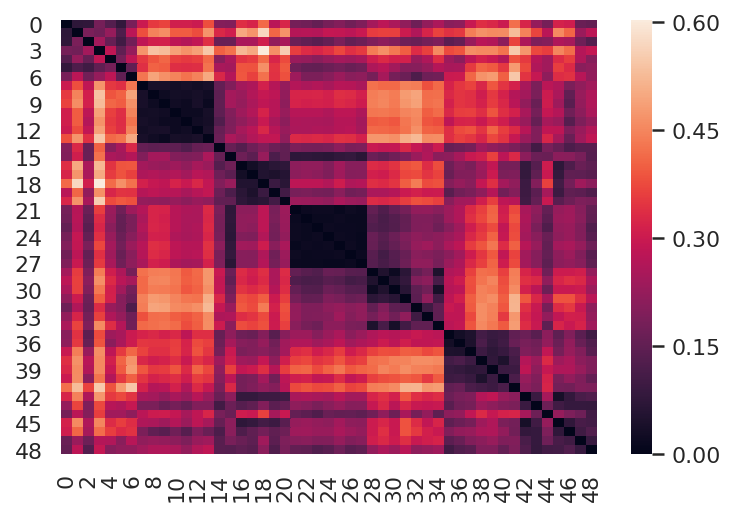

In [25]:
vgg16_bn_rdm = get_rdm(alt_model_feat)

sns.heatmap(vgg16_bn_rdm)
plt.show()

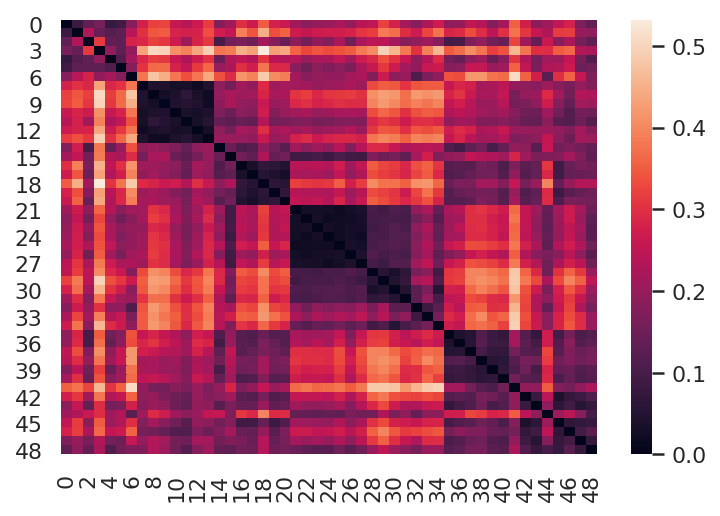

In [23]:
model_features = extract_features(X,agent.model)

model_rdm = get_rdm(model_features)
sns.heatmap(model_rdm)
plt.show()

In [ ]:
model_features = extract_features(X,agent.model)

model_rdm = get_rdm(model_features)
sns.heatmap(model_rdm)
plt.show()

In [ ]:
sns.heatmap(custom_rdm)
plt.show()